# This notebook analyses reconstruction results on the physionet 2015 challenge dataset

In [1]:
# Importing packages
import os
import datetime
import wfdb
import pywt
import seaborn
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from os.path import join as osj
import os
import pandas as pd
from pathlib import Path
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from collections import Counter

In [2]:
from pathlib import Path
from collections import Counter
import pandas as pd

# === Configuration ===
folder_path = Path("arythmia")
hea_files = sorted(folder_path.glob("*.hea"))

# === Trackers for only true alarms ===
true_alarm_files = []
true_alarm_case_ids = []
arrhythmia_types = []

# === Scan .hea files ===
for hea_file in hea_files:
    with open(hea_file, "r") as f:
        lines = f.readlines()

    signal_lines = [line for line in lines if not line.startswith("#")]
    label_lines = [line.strip() for line in lines if line.startswith("#")]

    # Check if both II and PLETH present
    has_lead_ii = any("II" in line.split()[-1] for line in signal_lines)
    has_pleth = any("PLETH" in line.split()[-1] for line in signal_lines)

    if has_lead_ii and has_pleth:
        # Extract alarm label
        label = next((l for l in label_lines if "alarm" in l.lower()), None)
        if label and "true" in label.lower():
            true_alarm_files.append(str(hea_file))
            true_alarm_case_ids.append(hea_file.stem)
            # Find arrhythmia type (first comment line not containing 'alarm')
            arrhythmia = next((line for line in label_lines if "alarm" not in line.lower()), None)
            arrhythmia = arrhythmia.lstrip("#").strip() if arrhythmia else "Unknown"
            arrhythmia_types.append(arrhythmia)

# === Save only true alarm files ===
Path("cache").mkdir(exist_ok=True)
true_alarm_file = "cache/true_alarms.txt"
with open(true_alarm_file, "w") as tf:
    for fpath in true_alarm_files:
        tf.write(f"{fpath}\n")
print(f"💾 Saved only true alarms to {true_alarm_file}")

# === Arrhythmia summary DataFrame ===
df = pd.DataFrame({"case_id": true_alarm_case_ids, "arrhythmia": arrhythmia_types})
arrhythmia_counts = Counter(df["arrhythmia"])
print(f"\n✅ Total true alarms: {len(true_alarm_files)}")
print("📊 True alarm counts per arrhythmia type:")
for arr, count in arrhythmia_counts.items():
    print(f"  - {arr}: {count}")


💾 Saved only true alarms to cache/true_alarms.txt

✅ Total true alarms: 229
📊 True alarm counts per arrhythmia type:
  - Asystole: 17
  - Bradycardia: 38
  - Ventricular_Flutter_Fib: 6
  - Tachycardia: 107
  - Ventricular_Tachycardia: 61


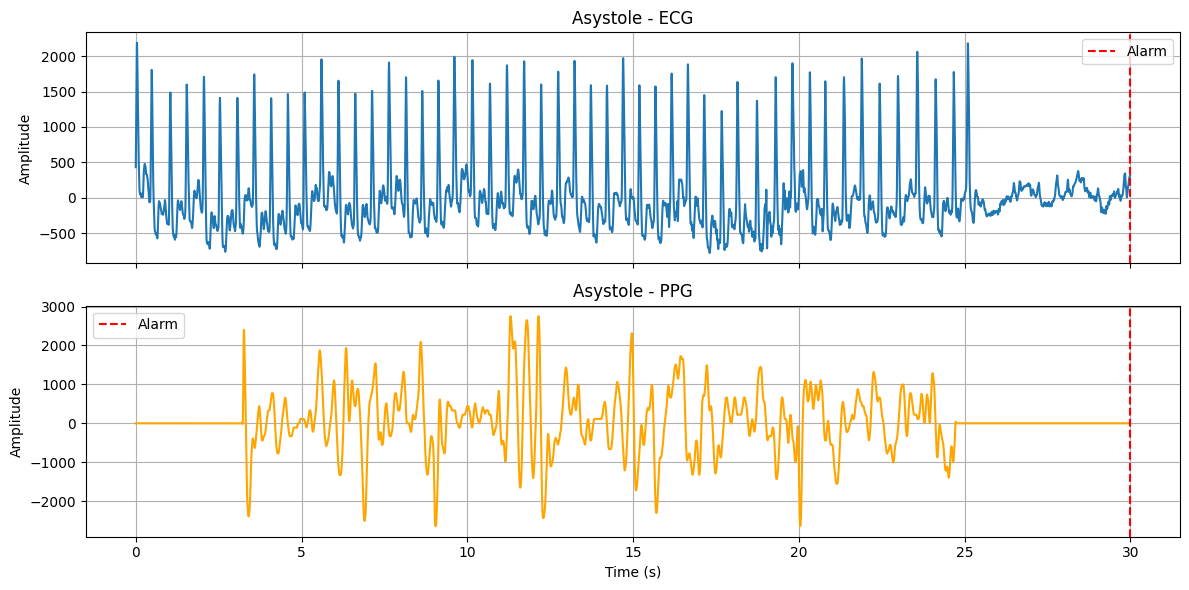

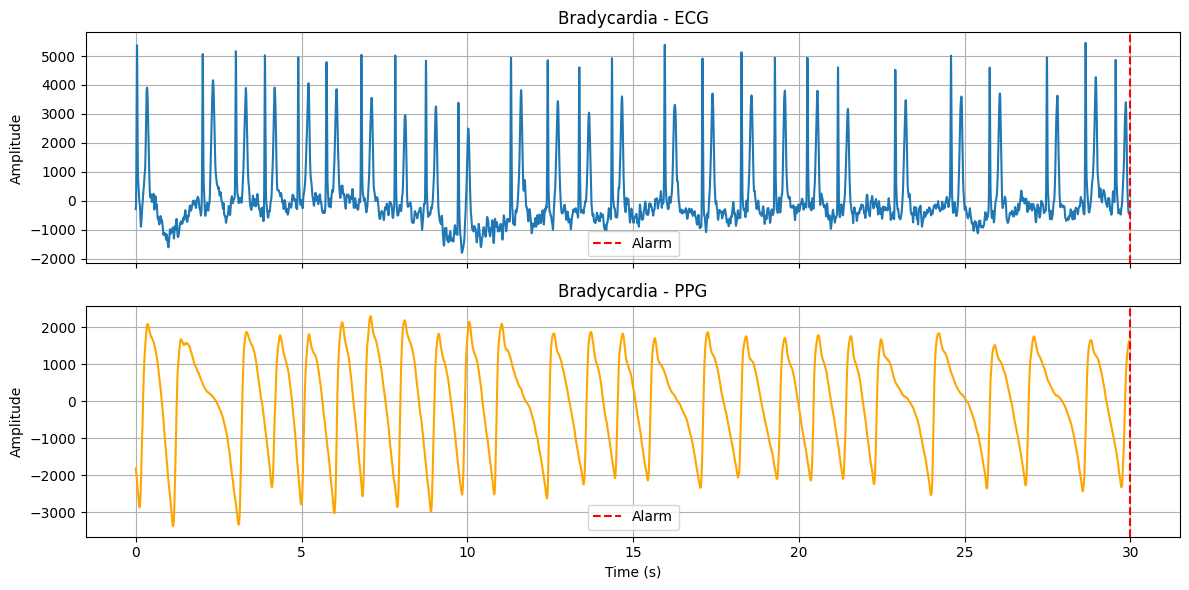

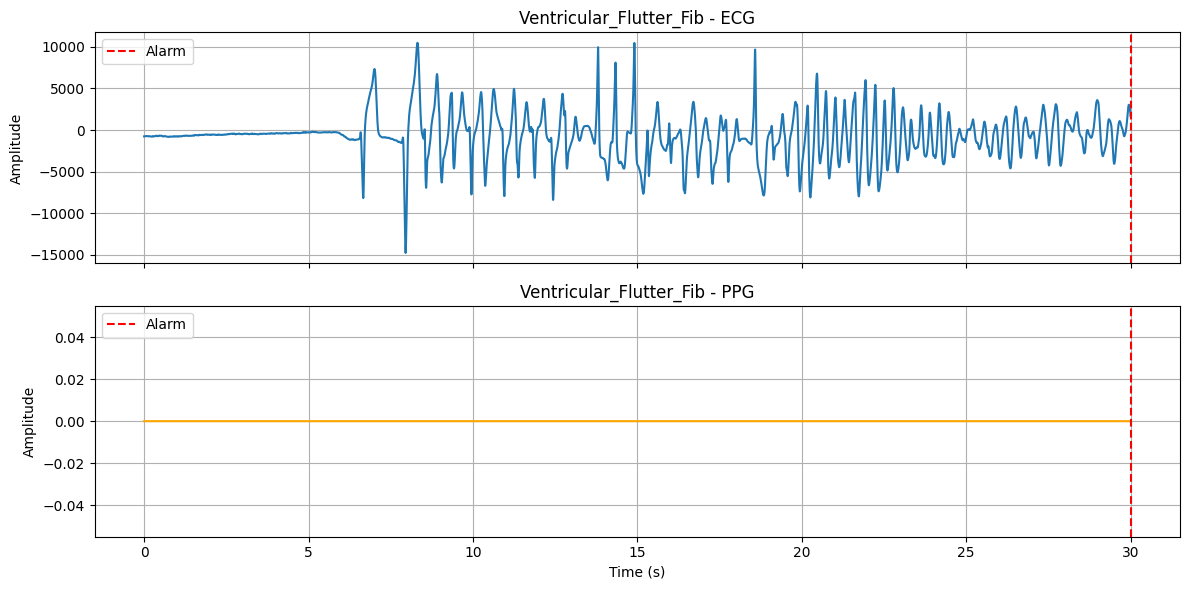

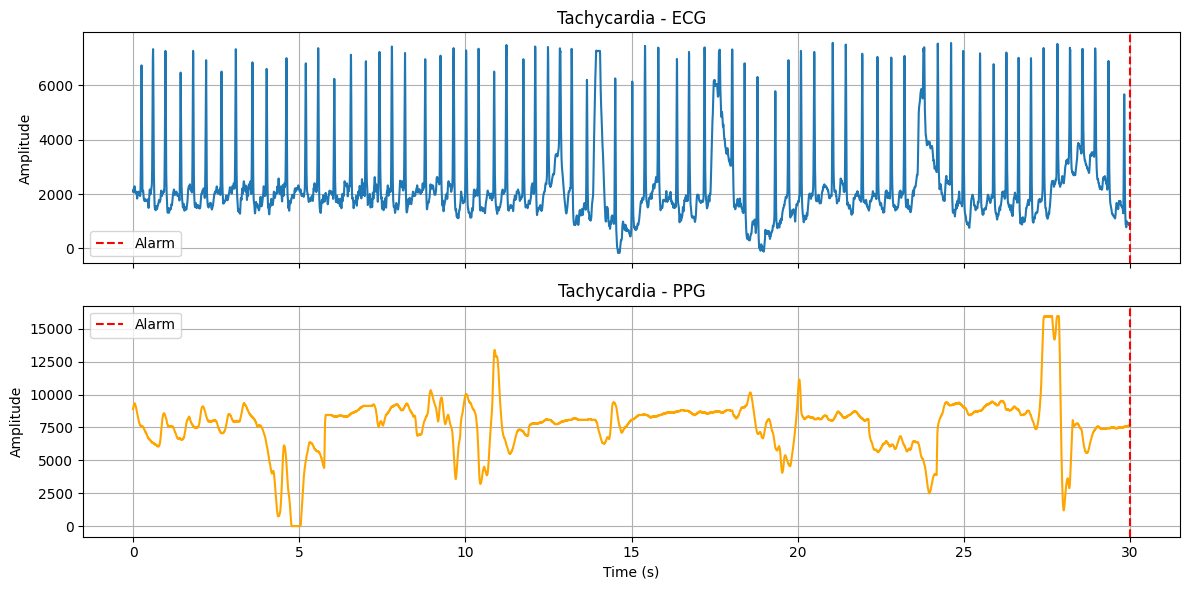

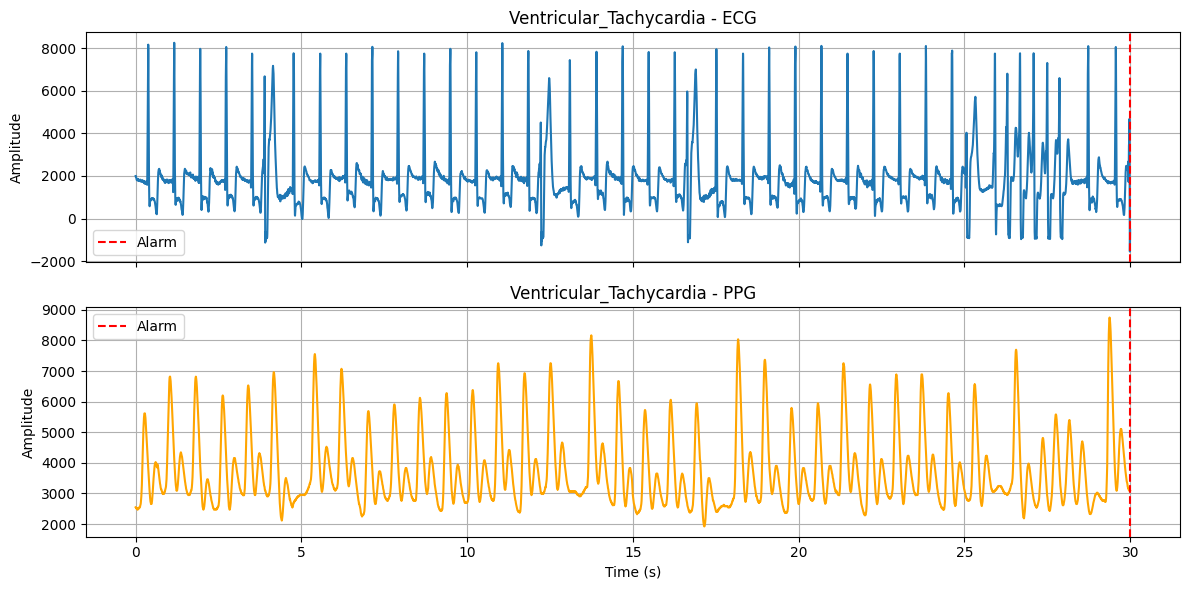

In [6]:
def load_signal_and_meta(hea_path):
    from scipy.io import loadmat
    import numpy as np

    mat_path = hea_path.with_suffix(".mat")
    signals = loadmat(mat_path)["val"]

    with open(hea_path, "r") as f:
        lines = f.readlines()

    labels = [line.split()[-1] for line in lines[1:4]]
    ecg_idx = labels.index("II")
    ppg_idx = labels.index("PLETH")
    fs = int(lines[0].split()[2])
    total_samples = int(lines[0].split()[3])
    alarm_index = fs*60*5  #5 minute mark

    return {
        "signals": signals,
        "ecg_idx": ecg_idx,
        "ppg_idx": ppg_idx,
        "fs": fs,
        "alarm_index": alarm_index,
    }


def plot_alarm_sections(hea_path, title_prefix):
    data = load_signal_and_meta(hea_path)
    fs = data["fs"]
    alarm = data["alarm_index"]
    window_sec = 10
    win_samples = window_sec * fs

    start_pre = max(0, alarm - win_samples)
    end_pre = alarm
    start_post = alarm
    end_post = min(data["signals"].shape[1], alarm + win_samples)


# === Configuration ===
fs = 250
pre_alarm_sec = 30
post_alarm_sec = 10
window_before = pre_alarm_sec * fs
window_after = post_alarm_sec * fs

# === Load valid true alarms with arrhythmia type ===
hea_files = Path("arythmia").glob("*.hea")
true_alarms = []

for hea_path in hea_files:
    with open(hea_path, "r") as f:
        lines = f.readlines()

    if not any("II" in l.split()[-1] for l in lines if not l.startswith("#")):
        continue
    if not any("PLETH" in l.split()[-1] for l in lines if not l.startswith("#")):
        continue

    comment_lines = [l.strip() for l in lines if l.startswith("#")]
    if any("true" in l.lower() for l in comment_lines):
        arrhythmia_type = comment_lines[0].replace("#", "").strip()
        true_alarms.append((arrhythmia_type, hea_path))

# === Pick one example per arrhythmia type ===
selected_examples = {}
for arr_type, path in true_alarms:
    if arr_type not in selected_examples:
        selected_examples[arr_type] = path

# === Plot function ===
def plot_alarm_context(hea_path, arrhythmia_label):
    data = load_signal_and_meta(hea_path)
    fs = data["fs"]
    alarm = data["alarm_index"]

    start = max(0, alarm - window_before)
    end = min(data["signals"].shape[1], alarm + window_after)

    ecg = data["signals"][data["ecg_idx"], start:end]
    ppg = data["signals"][data["ppg_idx"], start:end]
    t = np.arange(len(ecg)) / fs

    fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    axs[0].plot(t, ecg)
    axs[0].axvline((alarm - start) / fs, color="red", linestyle="--", label="Alarm")
    axs[0].set_title(f"{arrhythmia_label} - ECG")
    axs[0].set_ylabel("Amplitude")
    axs[0].grid()
    axs[0].legend()

    axs[1].plot(t, ppg, color="orange")
    axs[1].axvline((alarm - start) / fs, color="red", linestyle="--", label="Alarm")
    axs[1].set_title(f"{arrhythmia_label} - PPG")
    axs[1].set_ylabel("Amplitude")
    axs[1].set_xlabel("Time (s)")
    axs[1].grid()
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# === Run plotting ===
for arr_type, hea_path in selected_examples.items():
    plot_alarm_context(hea_path, arr_type)



In [4]:
import numpy as np
from scipy.signal import medfilt, iirnotch, filtfilt, periodogram, butter, filtfilt

def global_baseline_removal(signal, fs, window_sec=1.5):
    kernel_size = int(window_sec * fs)
    if kernel_size % 2 == 0:
        kernel_size += 1
    baseline = medfilt(signal, kernel_size=kernel_size)
    return signal - baseline

def apply_notch_filter(signal, fs, freq=60, Q=30):
    w0 = freq / (fs / 2)
    b, a = iirnotch(w0, Q)
    return filtfilt(b, a, signal)

def compute_noise_metrics(window, fs):
    f, Pxx = periodogram(window, fs)
    power_total = np.sum(Pxx)
    power_bw = np.sum(Pxx[f < 0.5]) / power_total if power_total > 0 else 0
    power_emg = np.sum(Pxx[f > 30]) / power_total if power_total > 0 else 0
    return power_bw, power_emg

def robust_z(metric):
    median = np.median(metric)
    mad = np.median(np.abs(metric - median))
    mad_scaled = 1.4826 * mad if mad > 0 else 1  # avoid division by zero
    return (np.array(metric) - median) / mad_scaled

def overlap_add(windows, starts, signal_length, window_size):
    reconstructed = np.zeros(signal_length)
    counts = np.zeros(signal_length)
    for w, start in zip(windows, starts):
        end = start + window_size
        reconstructed[start:end] += w
        counts[start:end] += 1
    counts[counts == 0] = 1  # avoid division by zero
    return reconstructed / counts

def adaptive_denoise_signal(signal, fs):
    """
    Denoises a 1D ECG or PPG signal using:
    - Global baseline wander removal
    - Global notch filter
    - Local BW removal
    - Local EMG noise removal

    Returns:
    - Filtered signal of same length
    """

    # 1️⃣ Global Baseline Wander Removal
    signal_clean = global_baseline_removal(signal, fs)

    # 2️⃣ Global Notch Filter for PLI
    signal_clean = apply_notch_filter(signal_clean, fs)

    # 3️⃣ Local Baseline Wander Removal (8s windows, 2s overlap)
    window_bw_sec = 8
    overlap_bw_sec = 2
    win_bw_samples = int(window_bw_sec * fs)
    overlap_bw_samples = int(overlap_bw_sec * fs)
    stride_bw_samples = win_bw_samples - overlap_bw_samples

    windows_bw = []
    starts_bw = []
    for start in range(0, len(signal_clean) - win_bw_samples + 1, stride_bw_samples):
        end = start + win_bw_samples
        windows_bw.append(signal_clean[start:end])
        starts_bw.append(start)

    # Compute BW noise metrics
    power_bw_list = []
    for w in windows_bw:
        power_bw, _ = compute_noise_metrics(w, fs)
        power_bw_list.append(power_bw)

    z_bw = robust_z(power_bw_list)

    # Apply local BW filtering
    filtered_windows_bw = []
    for i, w in enumerate(windows_bw):
        w_filtered = w.copy()
        if z_bw[i] > 2:
            w_filtered = global_baseline_removal(w_filtered, fs, window_sec=1.0)
        filtered_windows_bw.append(w_filtered)

    # Reconstruct signal after BW step
    signal_bw_clean = overlap_add(filtered_windows_bw, starts_bw, len(signal_clean), win_bw_samples)

    # 4️⃣ Local EMG Noise Removal (4s windows, 1s overlap)
    window_emg_sec = 4
    overlap_emg_sec = 1
    win_emg_samples = int(window_emg_sec * fs)
    overlap_emg_samples = int(overlap_emg_sec * fs)
    stride_emg_samples = win_emg_samples - overlap_emg_samples

    windows_emg = []
    starts_emg = []
    for start in range(0, len(signal_bw_clean) - win_emg_samples + 1, stride_emg_samples):
        end = start + win_emg_samples
        windows_emg.append(signal_bw_clean[start:end])
        starts_emg.append(start)

    # Compute EMG noise metrics
    power_emg_list = []
    for w in windows_emg:
        _, power_emg = compute_noise_metrics(w, fs)
        power_emg_list.append(power_emg)

    z_emg = robust_z(power_emg_list)

    # Apply local EMG filtering
    filtered_windows_emg = []
    for i, w in enumerate(windows_emg):
        w_filtered = w.copy()
        if z_emg[i] > 2:
            b, a = butter(4, 40 / (fs / 2), btype='low')
            w_filtered = filtfilt(b, a, w_filtered)
        filtered_windows_emg.append(w_filtered)

    # Reconstruct final signal
    filtered_signal = overlap_add(filtered_windows_emg, starts_emg, len(signal_bw_clean), win_emg_samples)

    return filtered_signal


In [ ]:
import numpy as np
from scipy.io import loadmat
from pathlib import Path
import matplotlib.pyplot as plt


# === Load cases ===
with open("good_cases.txt") as f:
    good_cases = [Path(line.strip()) for line in f if line.strip()]

all_cases = good_cases

# === Config ===
before_alarm_sec = 15
alarm_win_sec = 10

# === Loop over examples ===
for i, hea_path in enumerate(all_cases[:5]):  # Show first 5 cases
    mat_path = hea_path.with_suffix(".mat")
    mat = loadmat(mat_path)
    signals = mat["val"]

    # Parse header
    with open(hea_path, "r") as f:
        lines = f.readlines()
    fs = int(lines[0].split()[2])
    labels = [line.split()[-1] for line in lines[1:5]]
    ecg_idx = labels.index("II")
    ppg_idx = labels.index("PLETH")
    total_samples = int(lines[0].split()[3])
    alarm_index = total_samples // 2  # midpoint is alarm region

    ecg = signals[ecg_idx]
    ppg = signals[ppg_idx]
    ecg_filt = adaptive_denoise_signal(ecg, fs)
    ppg_filt = adaptive_denoise_signal(ppg, fs)

    # === Define windows ===
    before_start = max(0, alarm_index - int((before_alarm_sec + alarm_win_sec) * fs))
    before_end = before_start + int(alarm_win_sec * fs)

    alarm_start = max(0, alarm_index - int(alarm_win_sec * fs // 2))
    alarm_end = alarm_start + int(alarm_win_sec * fs)

    # Time axes
    t_before = np.arange(before_end - before_start) / fs
    t_alarm = np.arange(alarm_end - alarm_start) / fs

    # === Plot both before and alarm sections ===
    fig, axs = plt.subplots(2, 2, figsize=(14, 6), sharex=False)
    axs[0, 0].plot(t_before, ecg[before_start:before_end], label="Original ECG")
    axs[0, 0].plot(t_before, ecg_filt[before_start:before_end], label="Filtered ECG", alpha=0.7)
    axs[0, 0].set_title("Before Alarm - ECG")
    axs[0, 0].legend()

    axs[1, 0].plot(t_before, ppg[before_start:before_end], label="Original PPG")
    axs[1, 0].plot(t_before, ppg_filt[before_start:before_end], label="Filtered PPG", alpha=0.7)
    axs[1, 0].set_title("Before Alarm - PPG")
    axs[1, 0].legend()

    axs[0, 1].plot(t_alarm, ecg[alarm_start:alarm_end], label="Original ECG")
    axs[0, 1].plot(t_alarm, ecg_filt[alarm_start:alarm_end], label="Filtered ECG", alpha=0.7)
    axs[0, 1].set_title("Alarm Region - ECG")
    axs[0, 1].legend()

    axs[1, 1].plot(t_alarm, ppg[alarm_start:alarm_end], label="Original PPG")
    axs[1, 1].plot(t_alarm, ppg_filt[alarm_start:alarm_end], label="Filtered PPG", alpha=0.7)
    axs[1, 1].set_title("Alarm Region - PPG")
    axs[1, 1].legend()

    for ax in axs.flat:
        ax.grid(True)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Amplitude")

    fig.suptitle(f"Case: {hea_path.stem}")
    plt.tight_layout()
    plt.show()


In [5]:
import numpy as np
from scipy.io import loadmat
from pathlib import Path

good_file_list = "good_cases.txt"
fs = 250

results = []

with open(good_file_list, "r") as f:
    good_files = [Path(line.strip()) for line in f if line.strip()]

for hea_path in good_files:
    mat_path = hea_path.with_suffix(".mat")
    try:
        # Load signal
        mat_data = loadmat(mat_path)
        signals = mat_data['val']
        num_samples = signals.shape[1]

        # Load alarm index
        with open(hea_path, "r") as fh:
            lines = fh.readlines()
        if len(lines[0].split()) > 3:
            total_samples = int(lines[0].split()[3])
            alarm_index = total_samples // 2
        else:
            alarm_index = num_samples // 2

        signal_length_sec = num_samples / fs

        print(f"{hea_path.name}: length={signal_length_sec:.1f}s, alarm_index={alarm_index} (sample)")

        results.append({
            "filename": hea_path.name,
            "length_sec": signal_length_sec,
            "samples": num_samples,
            "alarm_index": alarm_index
        })
    except Exception as e:
        print(f"❌ Error with {hea_path.name}: {e}")

# Optionally, save to CSV
import pandas as pd
pd.DataFrame(results).to_csv("good_file_lengths.csv", index=False)
print("\n💾 Summary saved to good_file_lengths.csv")


a161l.hea: length=330.0s, alarm_index=41250 (sample)
a185l.hea: length=330.0s, alarm_index=41250 (sample)
a345l.hea: length=330.0s, alarm_index=41250 (sample)
a442s.hea: length=300.0s, alarm_index=37500 (sample)
a443l.hea: length=330.0s, alarm_index=41250 (sample)
a446s.hea: length=300.0s, alarm_index=37500 (sample)
a449l.hea: length=330.0s, alarm_index=41250 (sample)
a604s.hea: length=300.0s, alarm_index=37500 (sample)
a654s.hea: length=300.0s, alarm_index=37500 (sample)
a796s.hea: length=300.0s, alarm_index=37500 (sample)
b124s.hea: length=300.0s, alarm_index=37500 (sample)
b125l.hea: length=330.0s, alarm_index=41250 (sample)
b183l.hea: length=330.0s, alarm_index=41250 (sample)
b228s.hea: length=300.0s, alarm_index=37500 (sample)
b229l.hea: length=330.0s, alarm_index=41250 (sample)
b265l.hea: length=330.0s, alarm_index=41250 (sample)
b269l.hea: length=330.0s, alarm_index=41250 (sample)
b299l.hea: length=330.0s, alarm_index=41250 (sample)
b515l.hea: length=330.0s, alarm_index=41250 (s

In [8]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from scipy.io import loadmat
from pathlib import Path
from models.ecg2ppg_model import ECG2PPGps, ECG2PPGps_loss
from models.ecg2ppg_LSTM_after import ECG2PPGpsThenLSTM
from utils.eval_metrics import compute_dtw, compute_pearson, compute_rmse

def normalize_signal(signal):
    signal = np.array(signal)
    signal = signal - np.mean(signal)
    std = np.std(signal)
    if std > 1e-6:
        signal = signal / std
    return signal

def set_random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def extract_signals_from_hea(hea_path):
    """Return dict with ECG, PPG, Fs, CaseID."""
    mat_path = hea_path.with_suffix(".mat")
    signals = loadmat(mat_path)["val"]  # shape: (n_channels, n_samples)
    with open(hea_path, "r") as f:
        lines = f.readlines()
    fs = int(lines[0].split()[2])
    case_id = hea_path.stem

    # Map row index to channel name (e.g., II, V, PLETH)
    signal_labels = []
    for i, line in enumerate(lines[1:]):
        if line.startswith("#"): continue
        label = line.split()[-1]
        signal_labels.append(label)
    # Find which row is II and which is PLETH
    try:
        ecg_idx = signal_labels.index("II")
        ppg_idx = signal_labels.index("PLETH")
    except ValueError as e:
        raise Exception(f"Could not find II or PLETH in {hea_path.name}: {e}")
    return {
        "CaseID": case_id,
        "ECG": signals[ecg_idx],
        "PPG": signals[ppg_idx],
        "Fs": fs
    }

def train_model(data, ModelClass, model_label, output_folder, window_length_sec=8.192, overlap_sec=6.14400,
                max_epochs=500, batch_size=128, seed=42):
    os.makedirs(output_folder, exist_ok=True)
    set_random_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    cid = data['CaseID']
    # ---- Denoise before normalization ----
    ecg = adaptive_denoise_signal(data['ECG'], data['Fs'])
    ppg = adaptive_denoise_signal(data['PPG'], data['Fs'])

    # Fix: Crop to same length!
    min_len = min(len(ecg), len(ppg))
    ecg = ecg[:min_len]
    ppg = ppg[:min_len]

    
    ecg = normalize_signal(ecg)
    ppg = normalize_signal(ppg)

    fs = data['Fs']

    window_samples = int(window_length_sec * fs)
    overlap_samples = int(overlap_sec * fs)
    stride_samples = window_samples - overlap_samples

    def create_windows(signal, window_samples, stride_samples):
        n = len(signal)
        windows = []
        for start in range(0, n - window_samples + 1, stride_samples):
            windows.append(signal[start:start + window_samples])
        return np.array(windows)


    ppg_windows = create_windows(ppg, window_samples, stride_samples)
    ecg_windows = create_windows(ecg, window_samples, stride_samples)


    if len(ecg_windows) < 1:
        print(f"⚠️ Skipping Subject {cid}: Not enough windows.")
        return

    total_wins = len(ecg_windows)
    train_wins = int(0.8 * total_wins)
    train_idx = slice(0, train_wins)
    test_idx = slice(train_wins, total_wins)

    splits = {
        "train": (ppg_windows[train_idx], ecg_windows[train_idx]),
        "test": (ppg_windows[test_idx], ecg_windows[test_idx])
    }

    model = ModelClass(in_channels=1, out_channels=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=800, gamma=0.1)
    loss_fn = ECG2PPGps_loss

    train_ppg, train_ecg = splits["train"]
    train_dataset = TensorDataset(
        torch.tensor(train_ppg, dtype=torch.float32).unsqueeze(1),
        torch.tensor(train_ecg, dtype=torch.float32).unsqueeze(1)
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    total_steps = max_epochs * len(train_loader)
    progress_bar = tqdm(
        total=total_steps,
        desc=f"Subject {cid} - {model_label}",
        unit="batch",
        leave=False,    # <--- or leave=True if you only want one bar at end
        position=0
    )
    
    model.train()
    for epoch in range(max_epochs):
        for input_batch, target_batch in train_loader:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)
            optimizer.zero_grad()
            output_batch = model(input_batch)
            loss = loss_fn(output_batch, target_batch)
            loss.backward()
            optimizer.step()
            progress_bar.update(1)
        scheduler.step()
    
    progress_bar.close()

    save_path = os.path.join(output_folder, f"subject_{cid}_{model_label}_model.pth")
    torch.save(model.state_dict(), save_path)
    print(f"💾 Model saved: {save_path}")
    # === Evaluation ===
    model.eval()
    metrics = {"Window": [], "Split": [], "DTW": [], "Pearson": [], "RMSE": []}
    with torch.no_grad():
        for split_name, (ppg_win, ecg_win) in splits.items():
            dataset = TensorDataset(
                torch.tensor(ppg_win, dtype=torch.float32).unsqueeze(1),
                torch.tensor(ecg_win, dtype=torch.float32).unsqueeze(1)
            )
            loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
            all_outputs, all_targets = [], []

            for input_batch, target_batch in loader:
                input_batch = input_batch.to(device)
                output_batch = model(input_batch)
                all_outputs.append(output_batch.squeeze(1).cpu().numpy())
                all_targets.append(target_batch.squeeze(1).cpu().numpy())

            outputs = np.vstack(all_outputs)
            targets = np.vstack(all_targets)

            for i in range(len(outputs)):
                metrics["Window"].append(i)
                metrics["Split"].append(split_name)
                metrics["DTW"].append(compute_dtw(targets[i], outputs[i]))
                metrics["Pearson"].append(compute_pearson(targets[i], outputs[i]))
                metrics["RMSE"].append(compute_rmse(targets[i], outputs[i]))

    eval_df = pd.DataFrame(metrics)
    eval_path = os.path.join(output_folder, f"subject_{cid}_{model_label}_evaluation.csv")
    eval_df.to_csv(eval_path, index=False)
    print(f"💾 Evaluation saved: {eval_path}")

# === Main Loop over good_cases.txt ===
good_cases = []
with open("good_cases.txt") as f:
    for line in f:
        p = Path(line.strip())
        if p.exists():
            good_cases.append(p)
print(f"Found {len(good_cases)} good cases.")

good_cases = [
    Path("arythmia/v255l.hea"),
    Path("arythmia/v275l.hea"),
    Path("arythmia/v368s.hea")
]

for hea_path in good_cases:
    
    print(f"\n=== Processing {hea_path.name} ===")
    try:
        subj = extract_signals_from_hea(hea_path)
        # Model 1: ECG2PPGps
        train_model(subj, ECG2PPGps, "ECG2PPGps_no_pretrain", output_folder="subject_models_arythmia")
        # Model 2: ECG2PPGpsThenLSTM
        train_model(subj, ECG2PPGpsThenLSTM, "ECG2PPGpsThenLSTM_no_pretrain", output_folder="subject_models_arythmia")
    except Exception as e:
        print(f"❌ Error with {hea_path.name}: {e}")


Found 46 good cases.

=== Processing v255l.hea ===


💾 Model saved: subject_models_arythmia\subject_v255l_ECG2PPGps_no_pretrain_model.pth
💾 Evaluation saved: subject_models_arythmia\subject_v255l_ECG2PPGps_no_pretrain_evaluation.csv


💾 Model saved: subject_models_arythmia\subject_v255l_ECG2PPGpsThenLSTM_no_pretrain_model.pth
💾 Evaluation saved: subject_models_arythmia\subject_v255l_ECG2PPGpsThenLSTM_no_pretrain_evaluation.csv

=== Processing v275l.hea ===


💾 Model saved: subject_models_arythmia\subject_v275l_ECG2PPGps_no_pretrain_model.pth
💾 Evaluation saved: subject_models_arythmia\subject_v275l_ECG2PPGps_no_pretrain_evaluation.csv


💾 Model saved: subject_models_arythmia\subject_v275l_ECG2PPGpsThenLSTM_no_pretrain_model.pth
💾 Evaluation saved: subject_models_arythmia\subject_v275l_ECG2PPGpsThenLSTM_no_pretrain_evaluation.csv

=== Processing v368s.hea ===


💾 Model saved: subject_models_arythmia\subject_v368s_ECG2PPGps_no_pretrain_model.pth
💾 Evaluation saved: subject_models_arythmia\subject_v368s_ECG2PPGps_no_pretrain_evaluation.csv


💾 Model saved: subject_models_arythmia\subject_v368s_ECG2PPGpsThenLSTM_no_pretrain_model.pth
💾 Evaluation saved: subject_models_arythmia\subject_v368s_ECG2PPGpsThenLSTM_no_pretrain_evaluation.csv


Found 46 good cases.


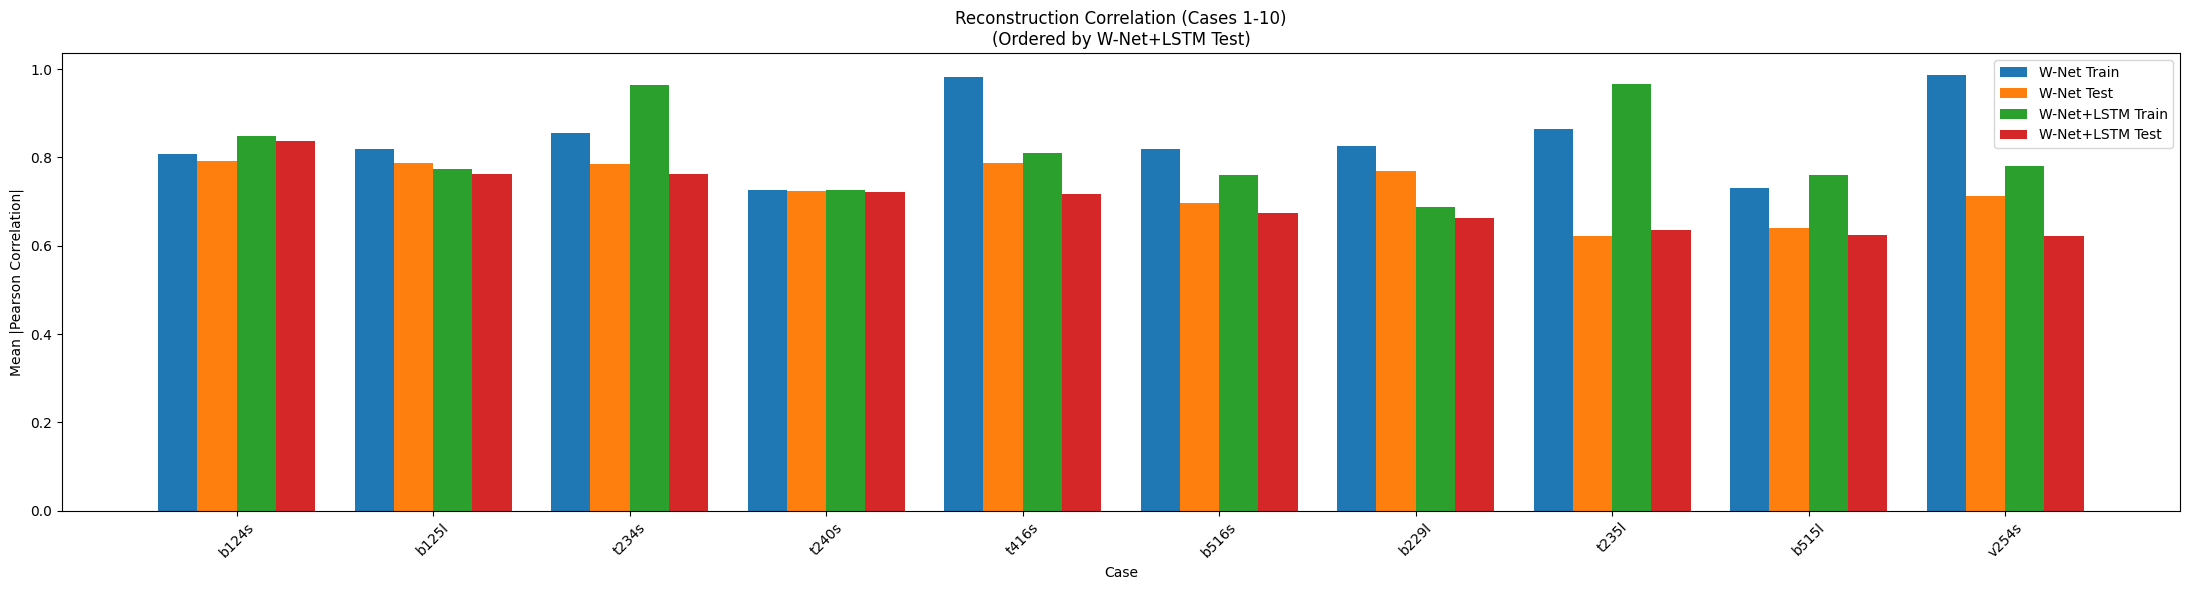

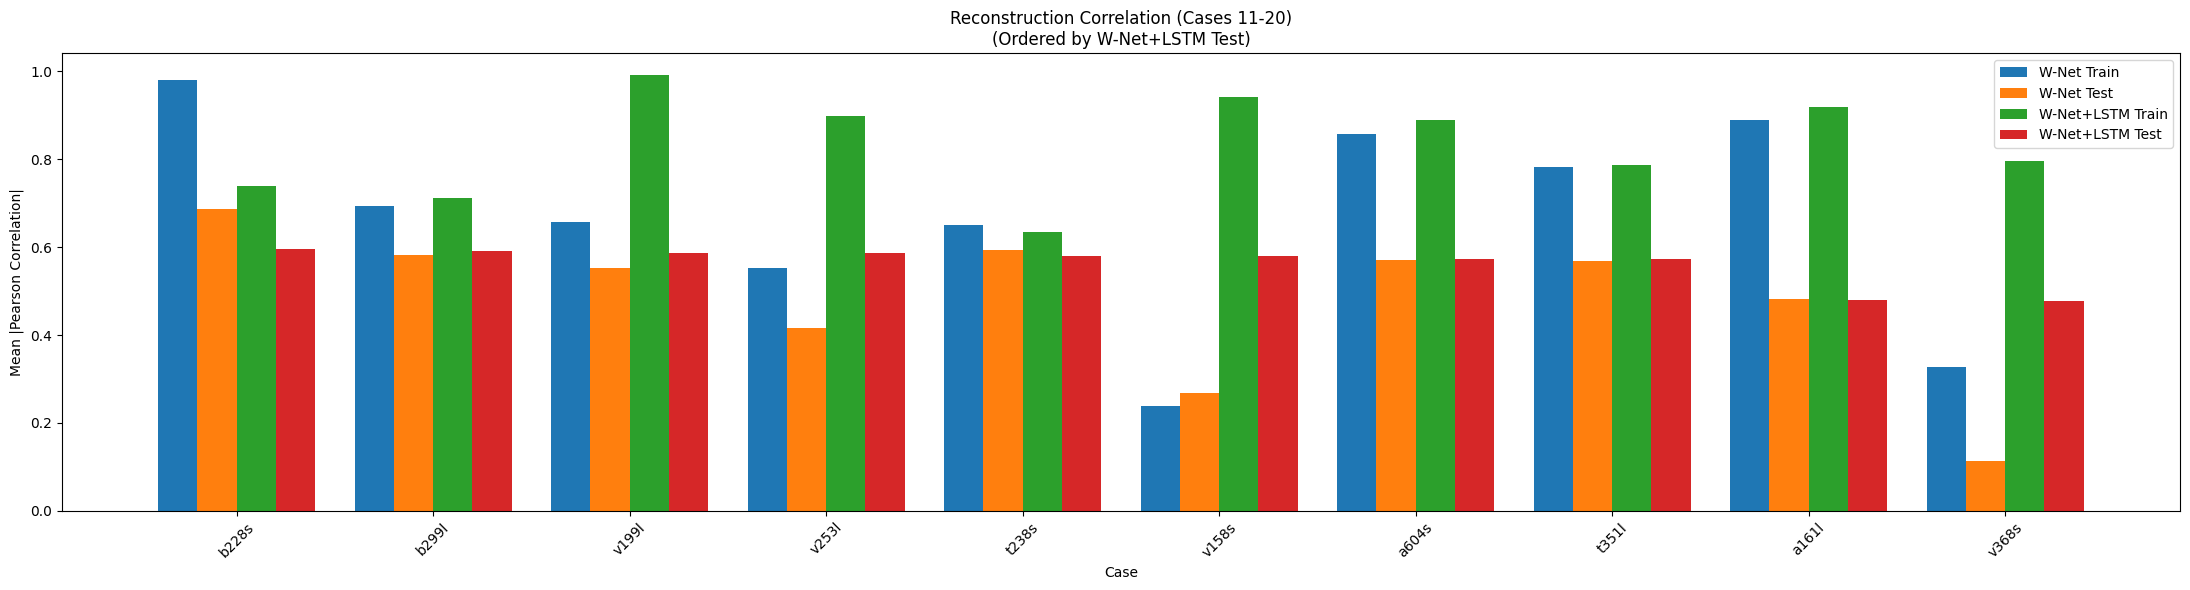

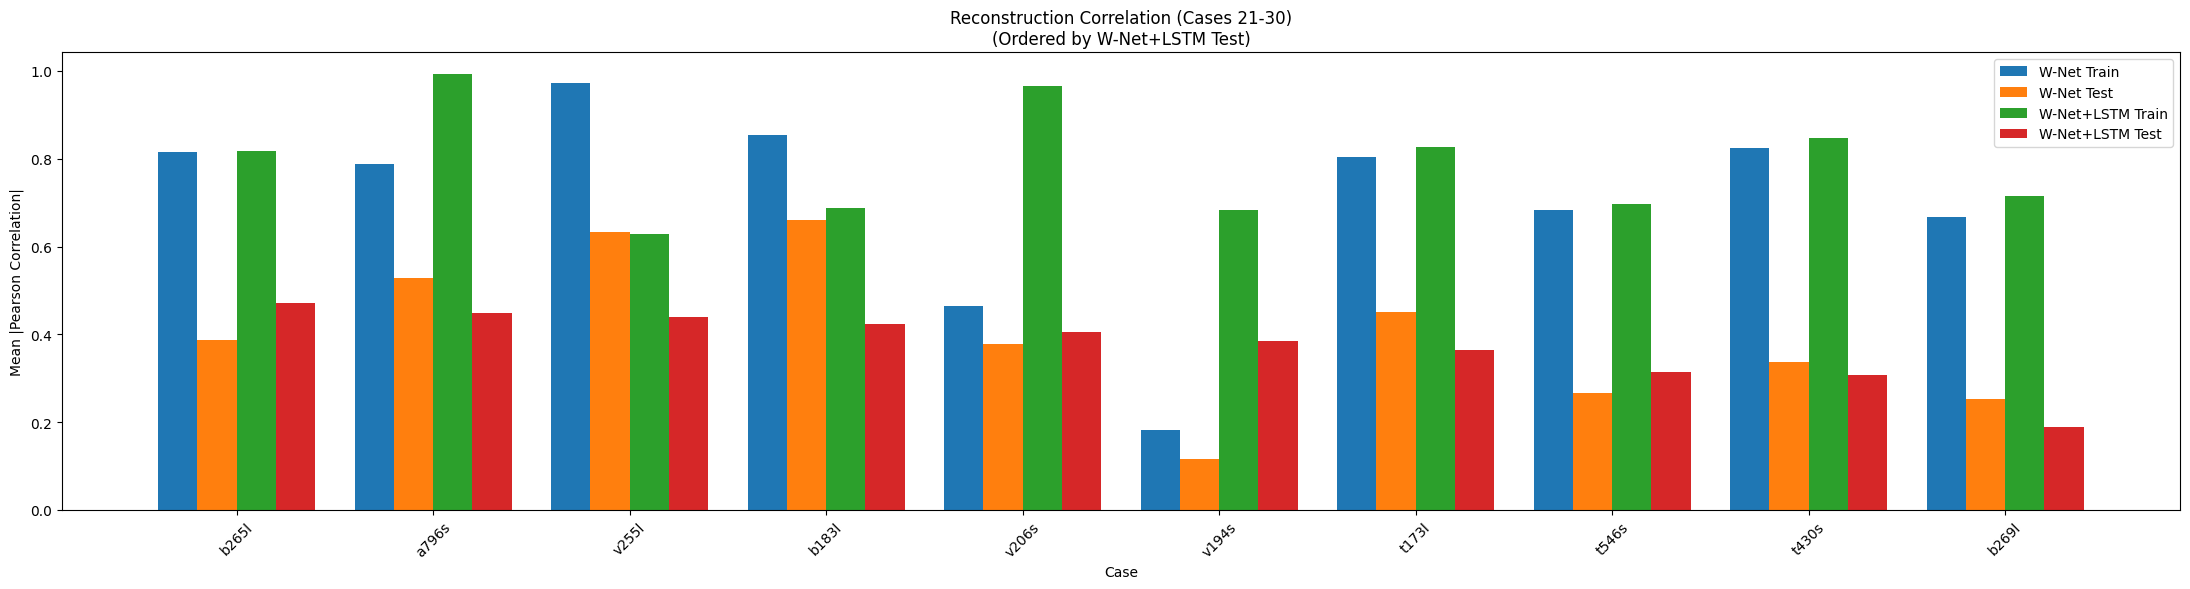

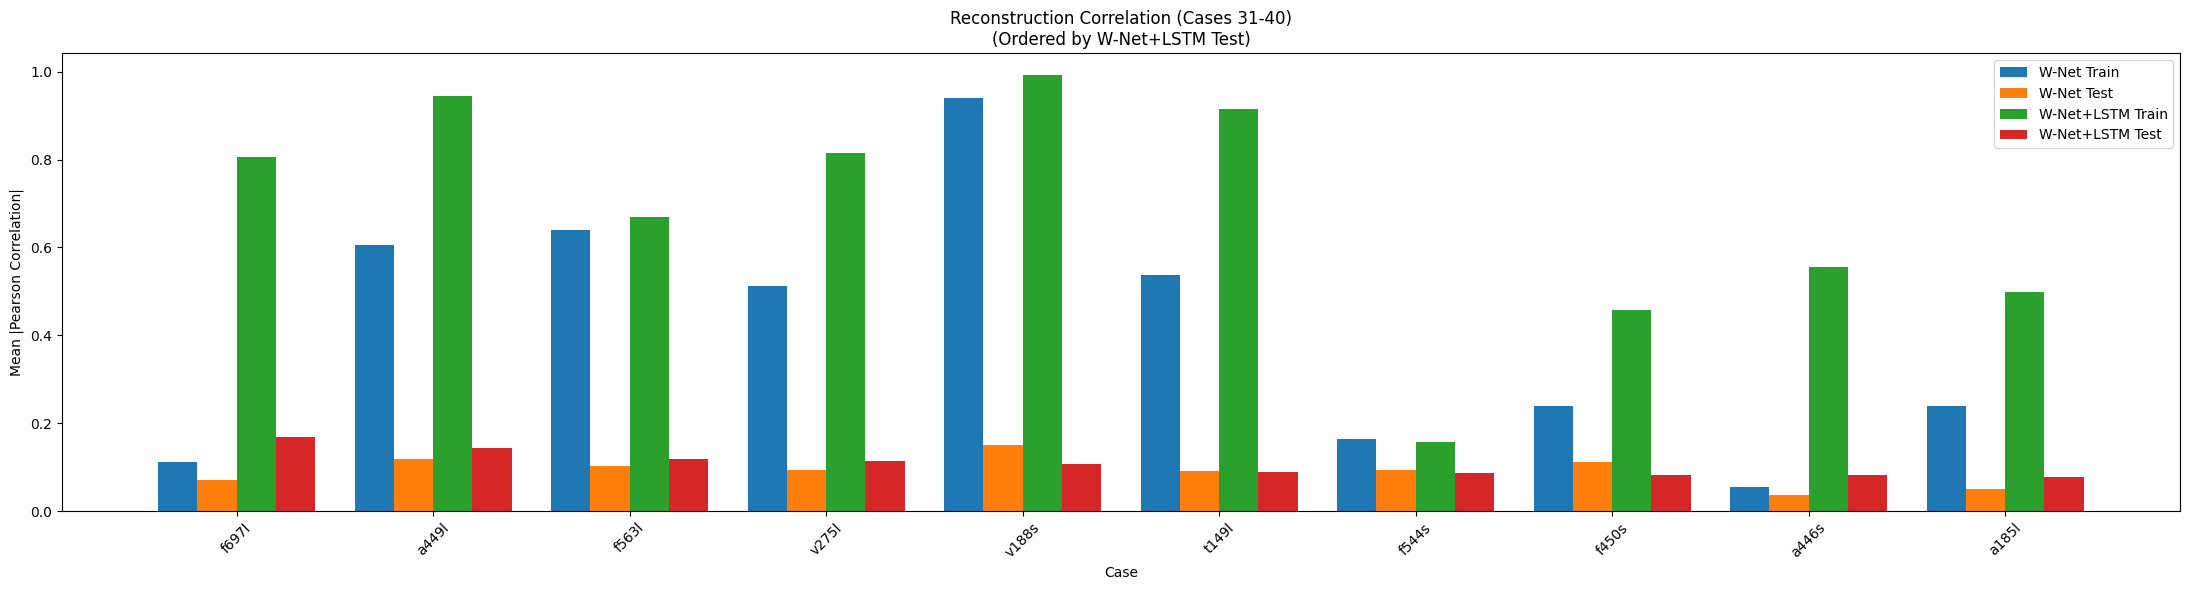

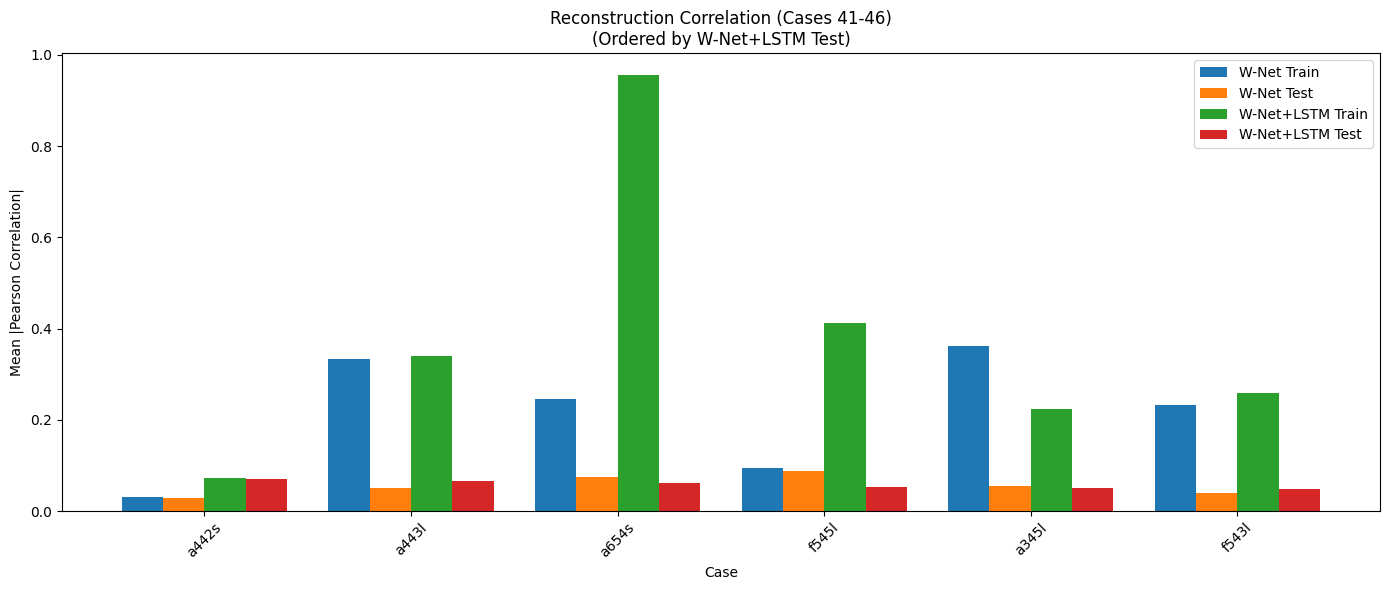

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# === Config ===
eval_dir = Path("subject_models_arythmia")
good_cases = []
with open("good_cases.txt") as f:
    for line in f:
        p = Path(line.strip())
        if p.exists():
            good_cases.append(p)
print(f"Found {len(good_cases)} good cases.")
case_list = good_cases
case_ids = [p.stem for p in case_list]

model_variants = [
    ("ECG2PPGps_no_pretrain", "W-Net"),
    ("ECG2PPGpsThenLSTM_no_pretrain", "W-Net+LSTM"),
]
splits = ["train", "test"]

results = []
for cid in case_ids:
    row = {"case_id": cid}
    for model_key, model_name in model_variants:
        eval_file = eval_dir / f"subject_{cid}_{model_key}_evaluation.csv"
        if not eval_file.exists():
            print(f"⚠️ Missing: {eval_file}")
            continue
        df = pd.read_csv(eval_file)
        for split in splits:
            mask = df["Split"].astype(str).str.lower() == split
            mean_corr = df.loc[mask, "Pearson"].abs().mean()
            row[f"{model_name}_{split}"] = mean_corr
    results.append(row)

res_df = pd.DataFrame(results).set_index("case_id")

# Sort by W-Net+LSTM test performance
sort_col = "W-Net+LSTM_test"
res_df = res_df.sort_values(sort_col, ascending=False)

# === Plot in groups of 10 ===
bar_width = 0.2
labels = ["W-Net Train", "W-Net Test", "W-Net+LSTM Train", "W-Net+LSTM Test"]
bar_cols = ["W-Net_train", "W-Net_test", "W-Net+LSTM_train", "W-Net+LSTM_test"]
offsets = [-1.5*bar_width, -0.5*bar_width, 0.5*bar_width, 1.5*bar_width]

chunk_size = 10
n_cases = len(res_df)
n_chunks = (n_cases + chunk_size - 1) // chunk_size

for i in range(n_chunks):
    start = i * chunk_size
    end = min((i+1) * chunk_size, n_cases)
    chunk = res_df.iloc[start:end]
    x = np.arange(len(chunk))
    
    plt.figure(figsize=(2 + len(chunk) * 2, 6))
    for col, label, off in zip(bar_cols, labels, offsets):
        plt.bar(x + off, chunk.get(col, np.nan), width=bar_width, label=label)
    
    plt.xticks(x, chunk.index, rotation=45)
    plt.ylabel("Mean |Pearson Correlation|")
    plt.xlabel("Case")
    plt.title(f"Reconstruction Correlation (Cases {start+1}-{end})\n(Ordered by W-Net+LSTM Test)")
    plt.legend()
    plt.tight_layout()
    plt.show()


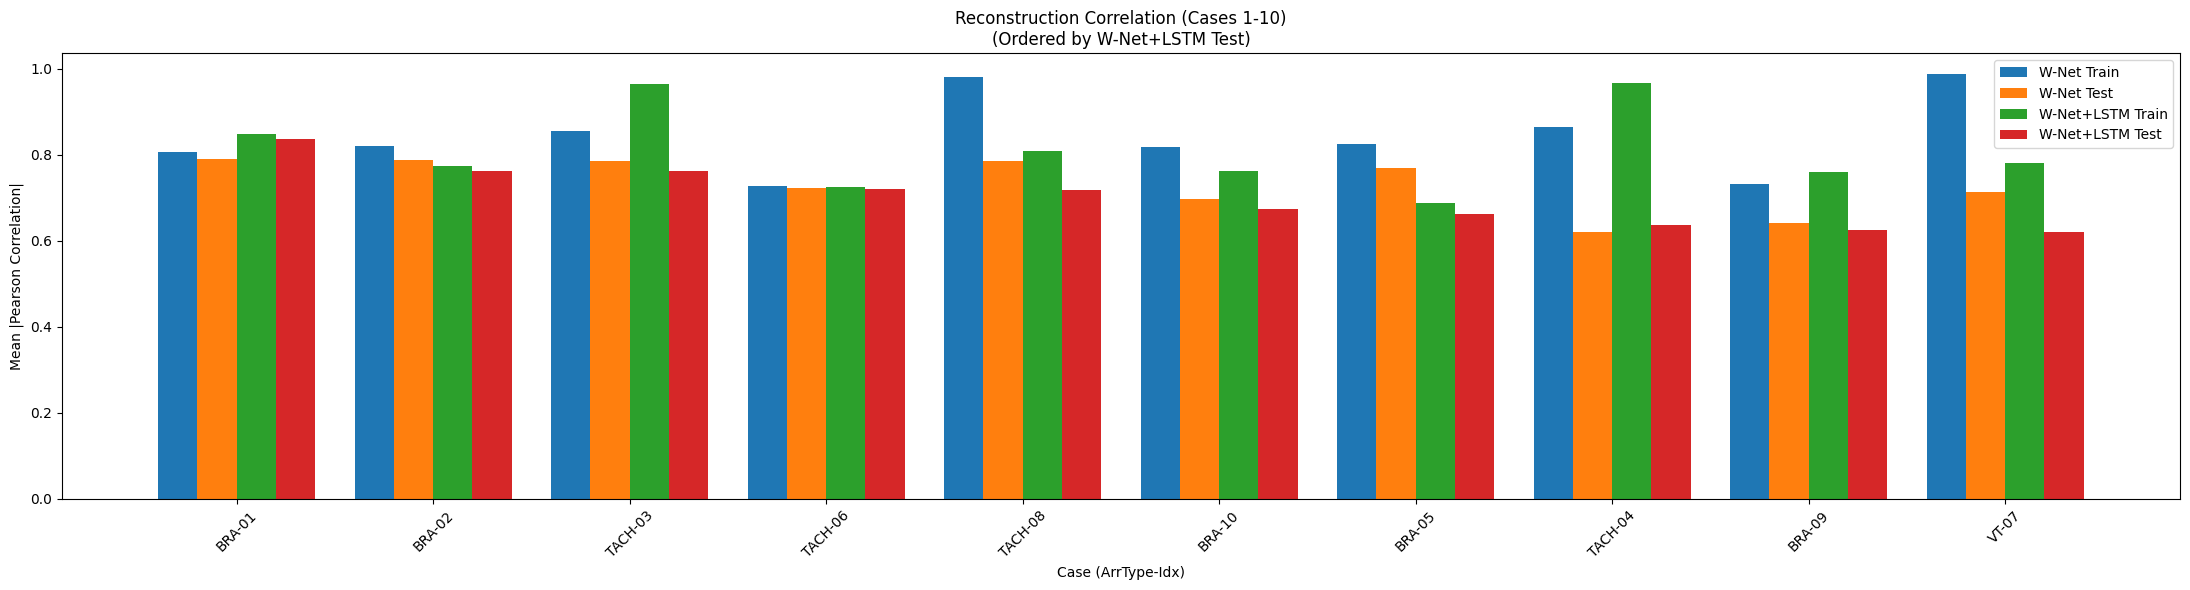

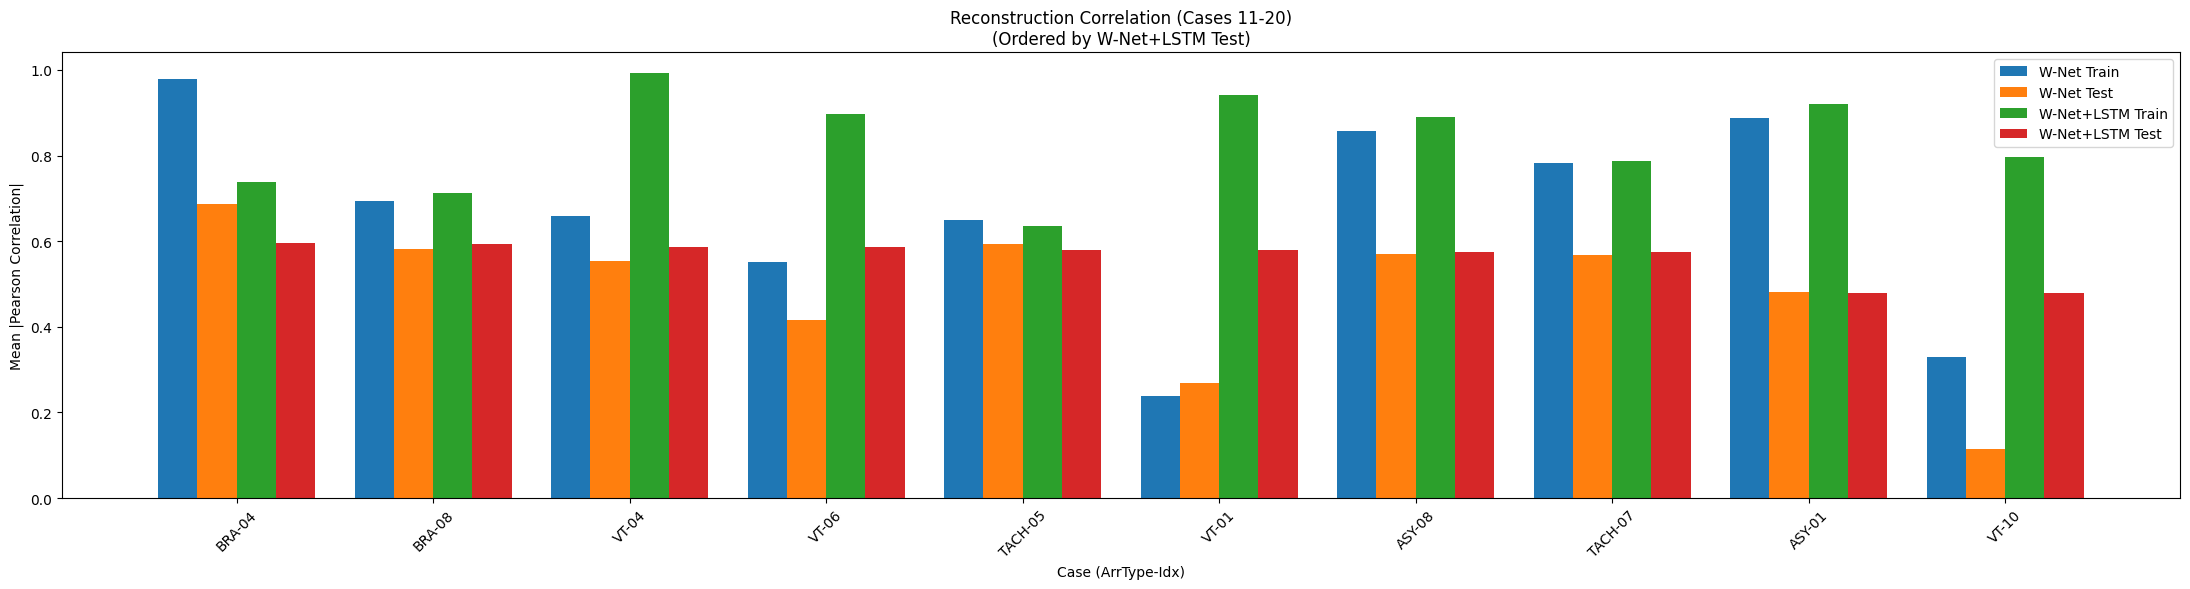

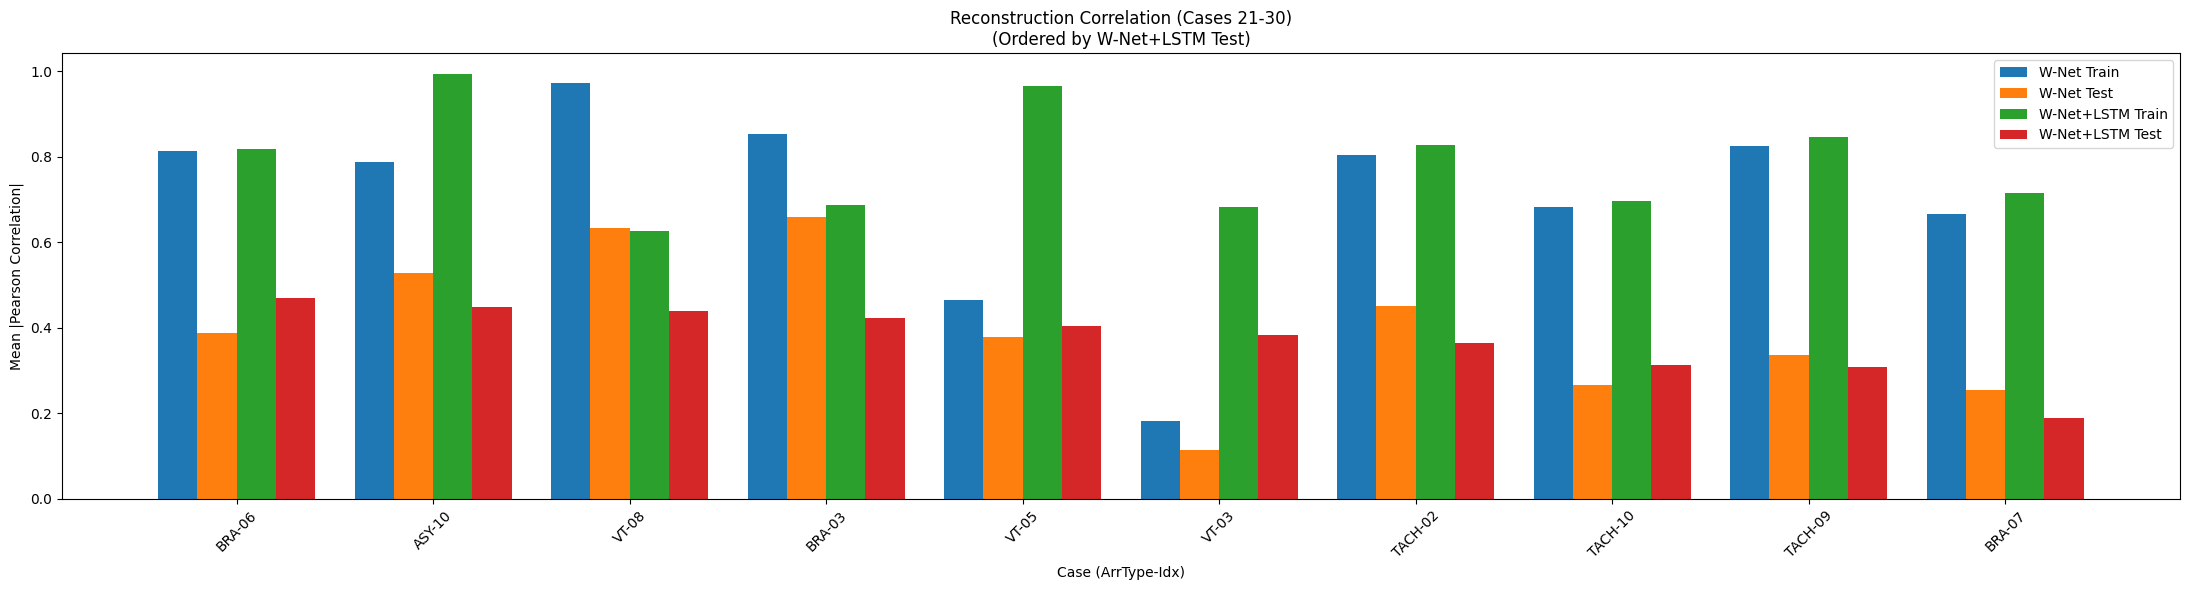

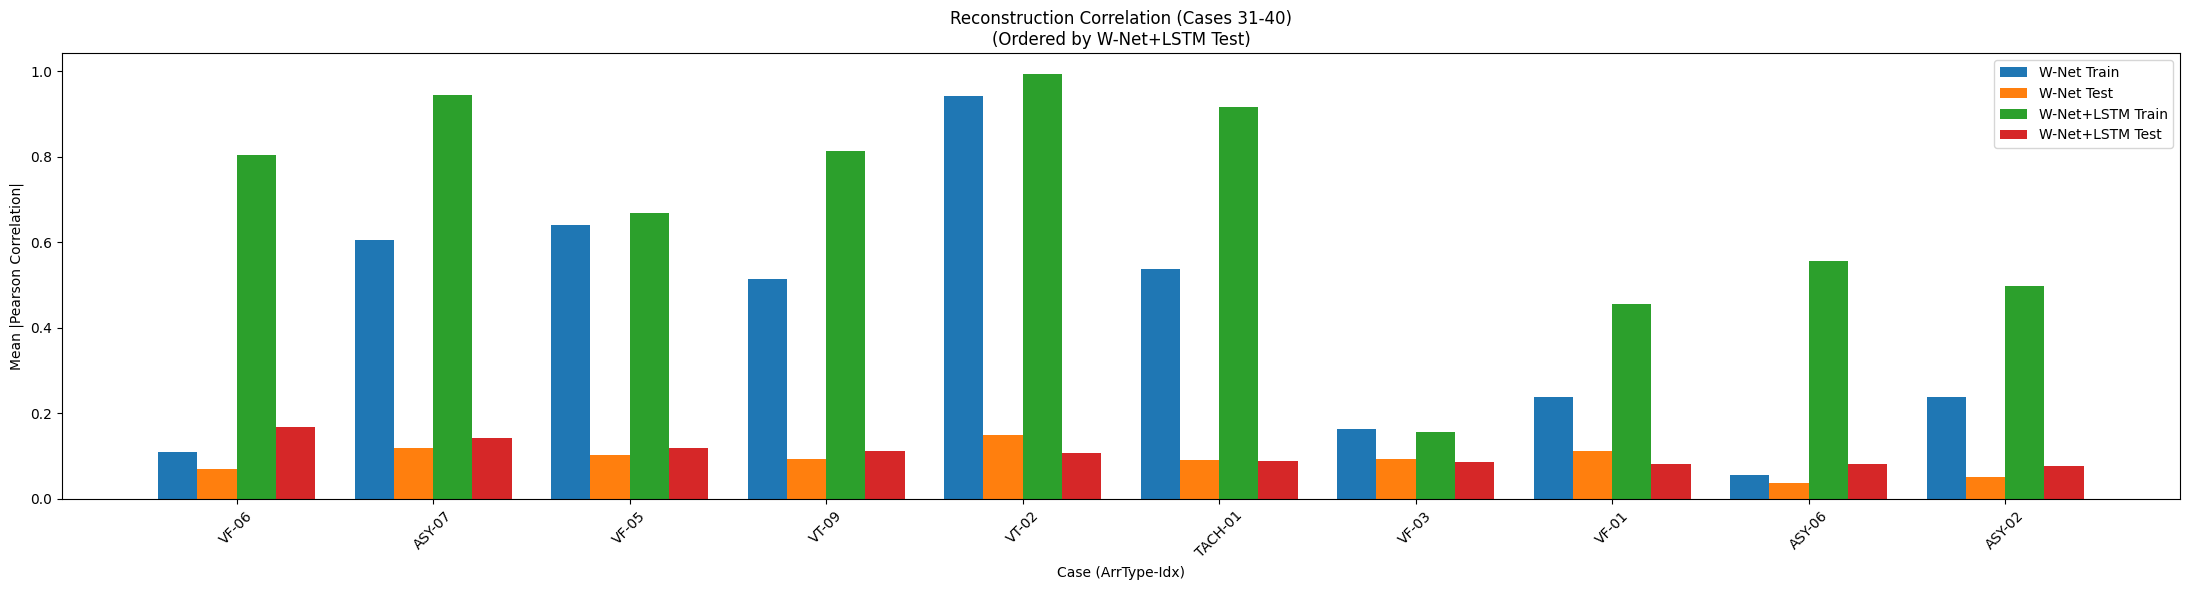

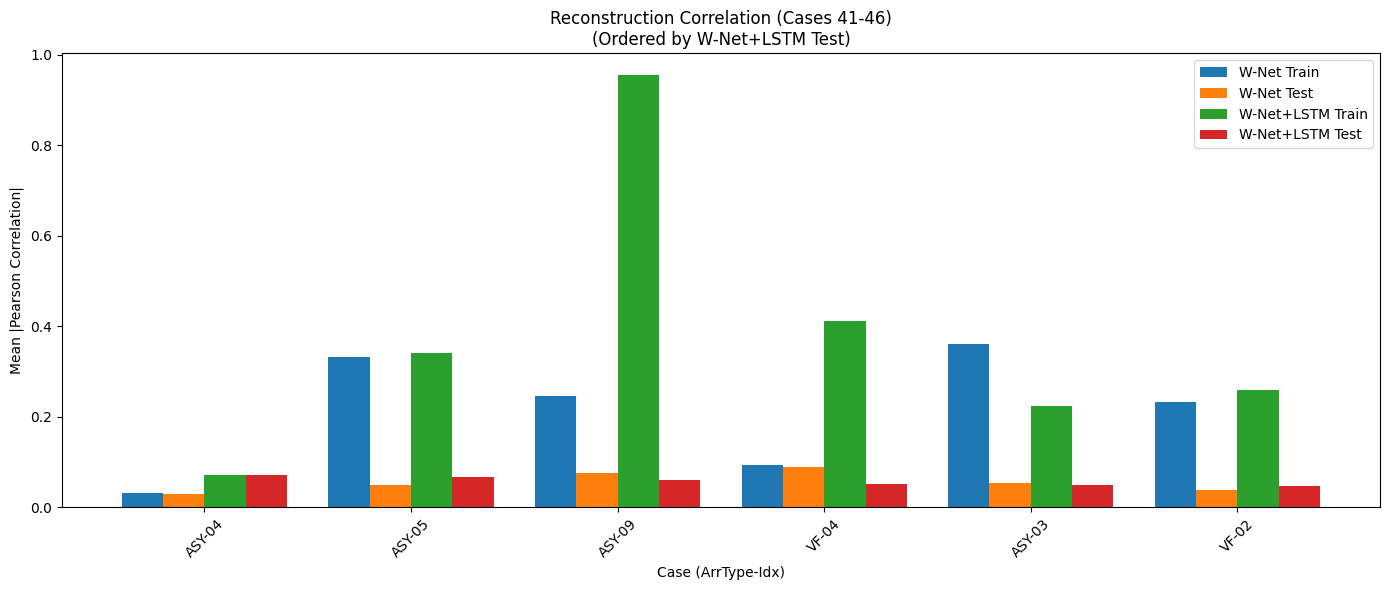

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# === Config ===
eval_dir = Path("subject_models_arythmia")
arrhythmia_map_path = "case_id_arrhythmia.csv"  # your mapping file: case_id,arrhythmia

# Load arrhythmia type mapping
arr_df = pd.read_csv(arrhythmia_map_path).set_index("case_id")
arr_dict = arr_df["arrhythmia"].to_dict()

def arr_short(arr):
    arr = arr.lower()
    if "ventricular_tachycardia" in arr: return "VT"
    if "ventricular_flut" in arr or "fibr" in arr: return "VF"
    if "brady" in arr: return "BRA"
    if "tachy" in arr: return "TACH"
    if "asystole" in arr: return "ASY"
    return arr[:4].upper()

model_variants = [
    ("ECG2PPGps_no_pretrain", "W-Net"),
    ("ECG2PPGpsThenLSTM_no_pretrain", "W-Net+LSTM"),
]
splits = ["train", "test"]

results = []
# Build group counter for within-type indices
group_counter = {}

for cid in arr_df.index:
    arr_type = arr_dict.get(cid, "UNK")
    arr_abbr = arr_short(arr_type)
    group_counter.setdefault(arr_abbr, 0)
    group_counter[arr_abbr] += 1
    idx = group_counter[arr_abbr]
    label = f"{arr_abbr}-{idx:02d}"
    row = {"case_id": cid, "arrhythmia": arr_type, "group_label": label}
    for model_key, model_name in model_variants:
        eval_file = eval_dir / f"subject_{cid}_{model_key}_evaluation.csv"
        if not eval_file.exists():
            continue
        df = pd.read_csv(eval_file)
        for split in splits:
            mask = df["Split"].astype(str).str.lower() == split
            mean_corr = df.loc[mask, "Pearson"].abs().mean()
            row[f"{model_name}_{split}"] = mean_corr
    results.append(row)

res_df = pd.DataFrame(results).set_index("case_id")

# Sort by W-Net+LSTM test performance
sort_col = "W-Net+LSTM_test"
res_df = res_df.sort_values(sort_col, ascending=False)

# === Plot in groups of 10 ===
bar_width = 0.2
labels = ["W-Net Train", "W-Net Test", "W-Net+LSTM Train", "W-Net+LSTM Test"]
bar_cols = ["W-Net_train", "W-Net_test", "W-Net+LSTM_train", "W-Net+LSTM_test"]
offsets = [-1.5*bar_width, -0.5*bar_width, 0.5*bar_width, 1.5*bar_width]

chunk_size = 10
n_cases = len(res_df)
n_chunks = (n_cases + chunk_size - 1) // chunk_size

for i in range(n_chunks):
    start = i * chunk_size
    end = min((i+1) * chunk_size, n_cases)
    chunk = res_df.iloc[start:end]
    x = np.arange(len(chunk))
    xtick_labels = chunk["group_label"]
    
    plt.figure(figsize=(2 + len(chunk) * 2, 6))
    for col, label, off in zip(bar_cols, labels, offsets):
        plt.bar(x + off, chunk.get(col, np.nan), width=bar_width, label=label)
    
    plt.xticks(x, xtick_labels, rotation=45)
    plt.ylabel("Mean |Pearson Correlation|")
    plt.xlabel("Case (ArrType-Idx)")
    plt.title(f"Reconstruction Correlation (Cases {start+1}-{end})\n(Ordered by W-Net+LSTM Test)")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [25]:
import pandas as pd
from pathlib import Path

# === CONFIG ===
arrhythmia_map_csv = "case_id_arrhythmia.csv"
eval_folder = Path("subject_models_arythmia")  # path to your evaluation CSVs
model_labels = [
    "ECG2PPGps_no_pretrain",        # W-Net
    "ECG2PPGpsThenLSTM_no_pretrain" # W-Net+LSTM
]

# --- Load case_id to arrhythmia ---
arr_df = pd.read_csv(arrhythmia_map_csv)
arr_map = dict(zip(arr_df['case_id'], arr_df['arrhythmia']))

summary_records = []

for model_label in model_labels:
    # For each good case:
    for case_id, arrhythmia in arr_map.items():
        # Find evaluation CSV
        eval_path = eval_folder / f"subject_{case_id}_{model_label}_evaluation.csv"
        if not eval_path.exists():
            print(f"⚠️ Missing: {eval_path}")
            continue
        df = pd.read_csv(eval_path)
        # Split by 'train'/'test'
        for split in ["train", "test"]:
            split_df = df[df["Split"] == split]
            if split_df.empty:
                continue
            mean_corr = split_df["Pearson"].abs().mean()
            std_corr = split_df["Pearson"].abs().std()
            summary_records.append({
                "case_id": case_id,
                "arrhythmia": arrhythmia,
                "model": model_label,
                "split": split,
                "mean_corr": mean_corr,
                "std_corr": std_corr
            })

# Convert to DataFrame
summary_df = pd.DataFrame(summary_records)

# Group by arrhythmia, model, split
grouped = summary_df.groupby(['arrhythmia', 'model', 'split']).agg(
    mean_corr=('mean_corr', 'mean'),
    std_corr=('mean_corr', 'std'),
    n=('mean_corr', 'count')
).reset_index()

# Save and print
grouped.to_csv("arrhythmia_corr_summary.csv", index=False)

# For nice cell formatting: mean ± std
def fmt(m, s):
    if np.isnan(m): return ""
    return f"{m:.2f}±{s:.2f}"

# Pivot to wide format
pivot = grouped.pivot(index='arrhythmia', columns=['model', 'split'], values=['mean_corr', 'std_corr'])

# Build pretty table with mean±std per (model, split)
table = pd.DataFrame(index=pivot.index)
for model in model_labels:
    for split in ['train', 'test']:
        mean = pivot['mean_corr'][(model, split)]
        std = pivot['std_corr'][(model, split)]
        table[f"{model.replace('_no_pretrain','').replace('ECG2PPGpsThenLSTM','LSTM').replace('ECG2PPGps','WNet')}_{split}"] = [
            fmt(m, s) for m, s in zip(mean, std)
        ]

print("\n=== Arrhythmia Mean ± Std Correlation Table ===")
print(table)

# Optionally, save:
table.to_csv("arrhythmia_mean_std_corr_table.csv")




=== Arrhythmia Mean ± Std Correlation Table ===
                        WNet_train  WNet_test LSTM_train  LSTM_test
arrhythmia                                                         
Asystole                 0.44±0.32  0.20±0.23  0.64±0.34  0.21±0.21
Bradycardia              0.80±0.09  0.63±0.18  0.75±0.05  0.58±0.18
Tachycardia              0.77±0.13  0.52±0.23  0.82±0.11  0.51±0.22
Ventricular_Flutter_Fib  0.25±0.20  0.08±0.03  0.46±0.24  0.09±0.05
Ventricular_Tachycardia  0.58±0.30  0.34±0.23  0.85±0.13  0.43±0.19
